# Bitcoin Price Prediction with Regression Models

This notebook implements Linear Regression, Ridge Regression, and Lasso Regression models to predict Bitcoin prices using the preprocessed data.

Authors: Hoda Abokhadra, Philip Myint, Bryan Reynolds, Taha Wasiq 

In [1]:
import importlib
import BitcoinModeler

import importlib
importlib.reload(BitcoinModeler)

from BitcoinModeler import *


In [2]:
# Use LaTeX fonts for figures and set font size of tick labels.
plt.rc('text', usetex=True)
plt.rc('font', family='serif', weight='bold')
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
# Hex codes of Matplotlib Tableau color palette: blue, orange, green, red, purple, brown, pink, gray, olive, cyan. 
plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# XKCD colors (https://xkcd.com/color/rgb/): teal, magenta, sea green, bright pink, dark orange, goldenrod, forest, dirt, coral, baby blue, peach.
plot_colors.extend(['#029386', '#c20078', '#53fca1', '#fe01b1', '#c65102', '#fac205', '#0b5509', '#8a6e45', '#fc5a50', '#a2cffe', '#ffb07c'])

# Bitcoin Price Prediction

This notebook trains simple linear models for BTC price horizons **H1** (1 day) and **H7** (7 days), evaluates them on **Train/Validation/Test**, plots performance


## üß± Data & Splits

We load preprocessed CSVs for both horizons:

- **Train**: used to fit model parameters  
- **Validation (val)**: used to choose models/hyperparameters (no peeking at Test)  
- **Test**: used once at the end for an unbiased performance estimate




In [3]:
# Load h1 data
data_dir = './../data/processed/'
h1_train = pd.read_csv(data_dir + 'h1_vif_train.csv')
h1_val = pd.read_csv(data_dir + 'h1_vif_val.csv')
h1_test = pd.read_csv(data_dir + 'h1_vif_test.csv')

# Load h7 data
h7_train = pd.read_csv(data_dir + 'h7_vif_train.csv')
h7_val = pd.read_csv(data_dir + 'h7_vif_val.csv')
h7_test = pd.read_csv(data_dir + 'h7_vif_test.csv')

print(f"H1 - Train: {h1_train.shape}, Val: {h1_val.shape}, Test: {h1_test.shape}")
print(f"H7 - Train: {h7_train.shape}, Val: {h7_val.shape}, Test: {h7_test.shape}")

H1 - Train: (1877, 64), Val: (402, 64), Test: (403, 64)
H7 - Train: (1873, 64), Val: (401, 64), Test: (402, 64)


In [4]:
bundle_h1=BitcoinModeler.DataManager.prepare(h1_train, h1_val, h1_test, "y_btc_close_t+1", "H1")
bundle_h7=BitcoinModeler.DataManager.prepare(h7_train, h7_val, h7_test, "y_btc_close_t+7", "H7")

> Note: Features are **already z-score normalized using train-only stats** in `split.py` to avoid leakage.

In [5]:
# optional if you want to compare scaled vs unscaled 
#scaler_h1_cls = ScalerManager()
#bundle_h1_scaled = scaler_h1_cls.scale_bundle(bundle_h1)

#scaler_h7_cls = ScalerManager()
#bundle_h7_scaled = scaler_h7_cls.scale_bundle(bundle_h7)
#print("Class-based DataBundle objects created (both raw and scaled variants).")


## üöÄ Model Runs

We fit all three models on **H1 (1-day)** and **H7 (7-day)** horizons, then print per-split metrics.


In [6]:
# === Run experiments
importlib.reload(BitcoinModeler)
runner_h1 = BitcoinModeler.ExperimentRunner(bundle_h1, scaled=True)
df_h1 = runner_h1.run()

runner_h7 = BitcoinModeler.ExperimentRunner(bundle_h7, scaled=True)
df_h7 = runner_h7.run()


Bundle:  H1 Spline columns (selected): ['btc_roll_mean_close_7', 'btc_ema26', 'btc_atr14', 'btc_macd']
Bundle:  H1 Passthrough features     : 58
Bundle:  H1 Best params: {'pre__spl__n_knots': 8, 'ridge__alpha': 1.8816944249705557e-05} | Val MSE: 393.41333099670464
Bundle:  H7 Spline columns (selected): ['btc_ema26', 'btc_roll_mean_close_7', 'btc_atr14', 'btc_macd']
Bundle:  H7 Passthrough features     : 58
Bundle:  H7 Best params: {'pre__spl__n_knots': 8, 'ridge__alpha': 5.413360302965375} | Val MSE: 3277.182010920034


## üìä Results Table (All Models √ó Splits)


In [7]:

# Merge all for a single summary table 
results_df_classes = pd.concat([df_h1, df_h7], ignore_index=True)
print("\n‚Äî‚Äî‚Äî CLASS-BASED RESULTS SUMMARY ‚Äî‚Äî‚Äî")
print(results_df_classes.to_string(index=False, float_format="%.6f"))


‚Äî‚Äî‚Äî CLASS-BASED RESULTS SUMMARY ‚Äî‚Äî‚Äî
Horizon Scaled?               Model    Dataset             MSE        RMSE         MAE  RMSE_ND   MAE_ND        R2
     H1     Yes              Linear Validation      386.460641   19.658602   12.094807 0.130237 0.080127  0.983038
     H1     Yes              Linear       Test   235784.524346  485.576487  245.162722 0.105214 0.053121  0.988930
     H1     Yes               Ridge Validation      385.942785   19.645427   12.068995 0.130150 0.079956  0.983061
     H1     Yes               Ridge       Test   235463.199566  485.245504  244.951254 0.105142 0.053076  0.988945
     H1     Yes               Lasso Validation     2107.866438   45.911507   35.857607 0.304161 0.237555  0.907486
     H1     Yes               Lasso       Test   723901.897002  850.824246  500.400123 0.184355 0.108426  0.966013
     H1     Yes B Spline with Ridge Validation      393.413331   19.834650   12.180176 0.131404 0.080693  0.982733
     H1     Yes B Spline with R

## üìà Lasso Performance ‚Äî Validation vs Test

The chart below compares **Nonzero** vs **Zero** coefficients for each horizon (H1, H7).  



In [8]:
# Feature importance for Lasso models
lasso_h1 = [m for m in runner_h1.models if m.name == "Lasso"][0]
lasso_h7 = [m for m in runner_h7.models if m.name == "Lasso"][0]
H1LassoModelWrap = ModelWrapper("H1", lasso_h1.model)
H7LassoModelWrap = ModelWrapper("H7", lasso_h7.model)

Feature Importance Analysis


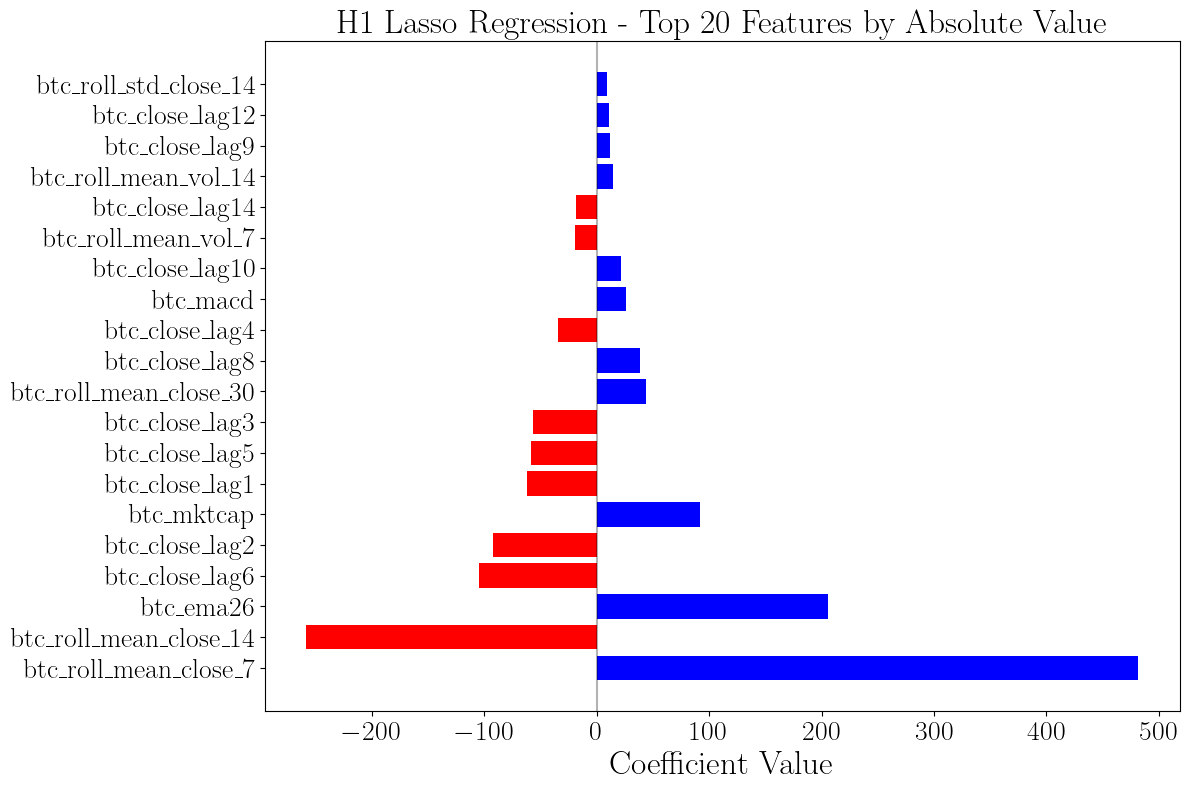

<Figure size 640x480 with 0 Axes>

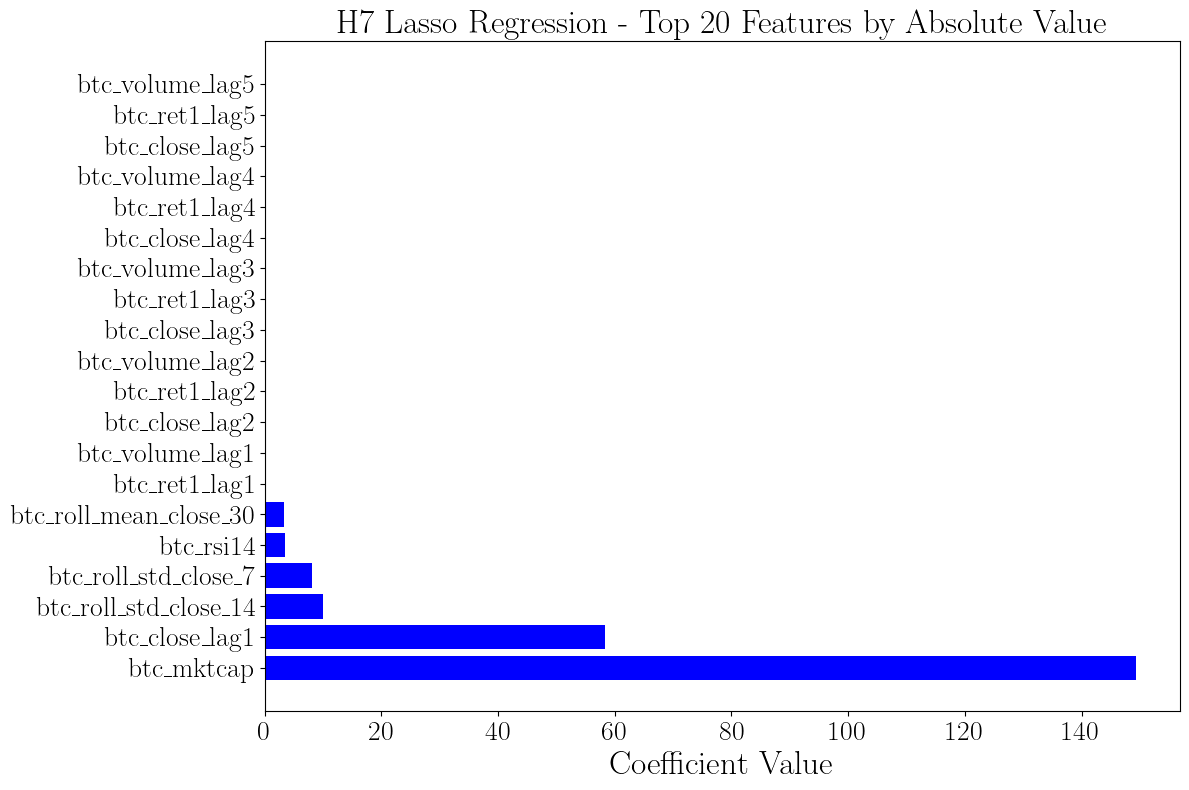

<Figure size 640x480 with 0 Axes>

In [9]:
print("Feature Importance Analysis")
print("="*50)
# H1 Lasso
h1_lasso_features = H1LassoModelWrap.plot_feature_importance(bundle_h1.feature_cols, 'H1 Lasso Regression', plot_name='figures/h1_lasso_coefs.pdf')
# H7 Lasso  
h7_lasso_features = H7LassoModelWrap.plot_feature_importance(bundle_h7.feature_cols, 'H7 Lasso Regression', plot_name='figures/h7_lasso_coefs.pdf')

## üìà Ridge Performance ‚Äî Validation vs Test

In [10]:
# Feature importance for Lasso models
ridge_h1 = [m for m in runner_h1.models if m.name == "Ridge"][0]
ridge_h7 = [m for m in runner_h7.models if m.name == "Ridge"][0]
H1RidgeModelWrap = ModelWrapper("H1", ridge_h1.model)
H7RidgeModelWrap = ModelWrapper("H7", ridge_h7.model)

Feature Importance Analysis


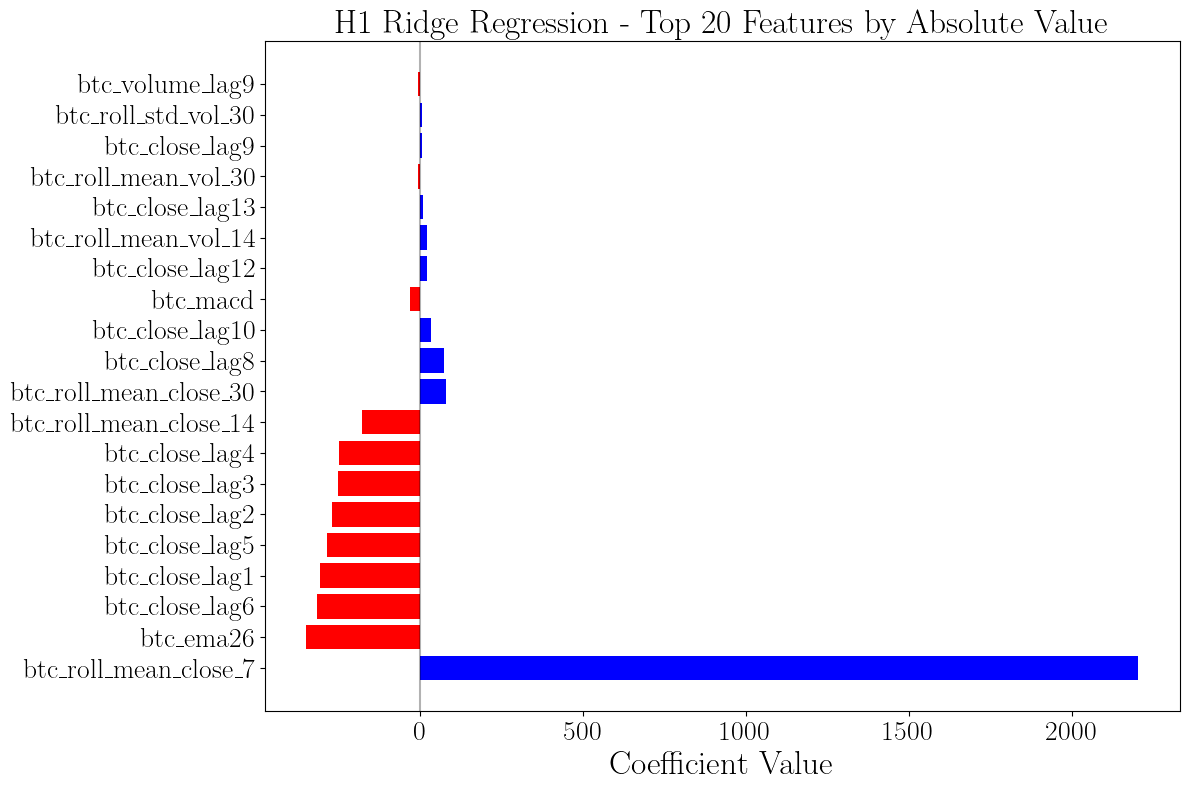

<Figure size 640x480 with 0 Axes>

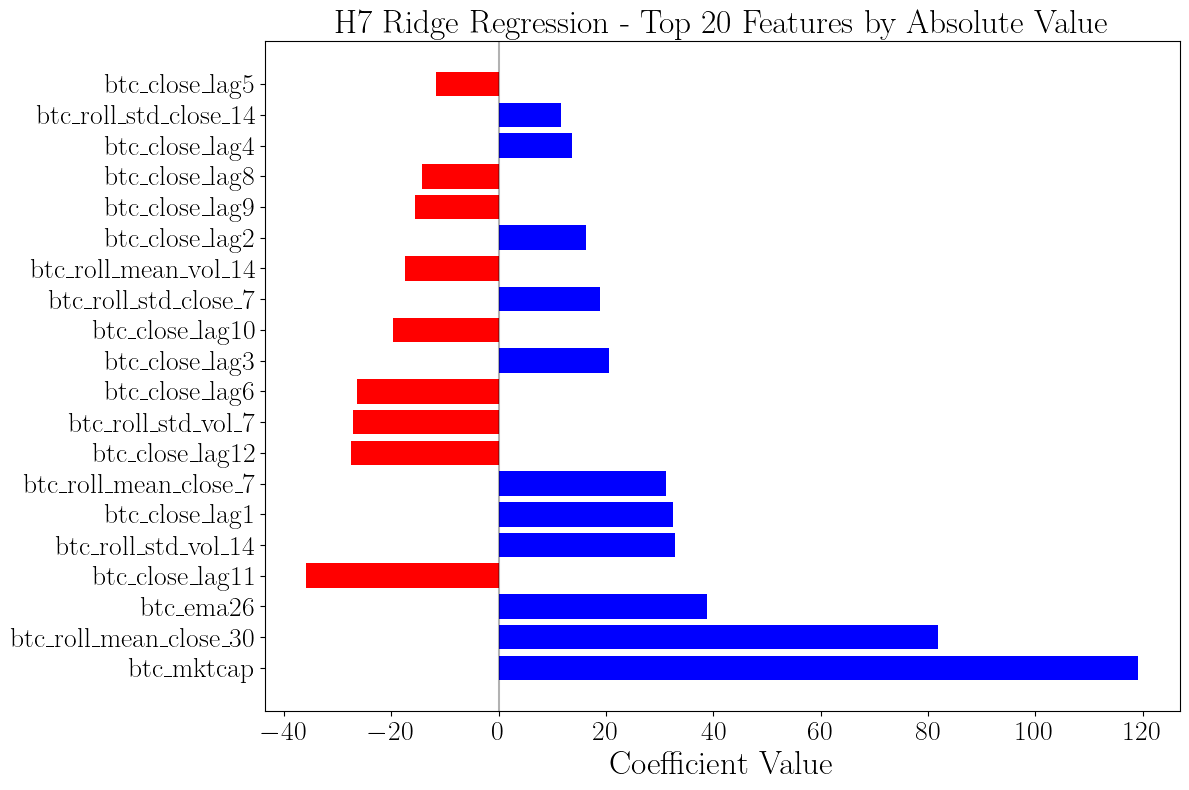

<Figure size 640x480 with 0 Axes>

In [11]:
print("Feature Importance Analysis")
print("="*50)
# H1 Ridge
h1_ridge_features = H1RidgeModelWrap.plot_feature_importance(bundle_h1.feature_cols, 'H1 Ridge Regression', plot_name='figures/h1_ridge_coefs.pdf')
# H7 Lasso  
h7_ridge_features = H7RidgeModelWrap.plot_feature_importance(bundle_h7.feature_cols, 'H7 Ridge Regression', plot_name='figures/h7_ridge_coefs.pdf')

## üèÜ Best Model Summary (Chosen by Validation RMSE)

For **each horizon**, we pick the model  with the **lowest Validation RMSE**, then report its **R2** and **Test_MSE** metrics.  



In [12]:
# -- Produce and print the best-model summary (pick by Validation RMSE; show Test metrics)
best_summary = ModelWrapper.best_summary(results_df_classes, metric="RMSE", prefer_scaled=None)
print("\n" + "="*80)
print("BEST MODEL SUMMARY ‚Äî picked by lowest Validation RMSE; Test metrics shown")
print("="*80)
print(best_summary.to_string(index=False, float_format="%.6f"))
print("\n" + "="*80)
print("BEST MODEL SUMMARY ‚Äî picked by lowest Validation R2; Test metrics shown")
print("="*80)
best_summaryR2 = ModelWrapper.best_summary(results_df_classes, metric="R2", prefer_scaled=None)
print(best_summaryR2.to_string(index=False, float_format="%.6f"))

H1LassoNonZeroCoef = H1LassoModelWrap.get_lasso_nonzero_coef()
H7LassoNonZeroCoef = H7LassoModelWrap.get_lasso_nonzero_coef()
result = (
    f"H1: {H1LassoNonZeroCoef}/{len(bundle_h1.feature_cols)} features selected | "
    f"H7: {H7LassoNonZeroCoef}/{len(bundle_h7.feature_cols)} features selected"
)
print("\nLasso coefficients (the rest are shrunk to zero): ",result)




BEST MODEL SUMMARY ‚Äî picked by lowest Validation RMSE; Test metrics shown
Horizon  Model Scaled?  Val_RMSE            MSE        RMSE        MAE  RMSE_ND   MAE_ND       R2
     H1  Ridge     Yes 19.645427  235463.199566  485.245504 244.951254 0.105142 0.053076 0.988945
     H7 Linear     Yes 55.365016 2184313.997933 1477.942488 799.256720 0.320175 0.173147 0.897488

BEST MODEL SUMMARY ‚Äî picked by lowest Validation R2; Test metrics shown
Horizon  Model Scaled?   Val_R2            MSE        RMSE        MAE  RMSE_ND   MAE_ND       R2
     H1  Ridge     Yes 0.983061  235463.199566  485.245504 244.951254 0.105142 0.053076 0.988945
     H7 Linear     Yes 0.865957 2184313.997933 1477.942488 799.256720 0.320175 0.173147 0.897488

Lasso coefficients (the rest are shrunk to zero):  H1: 62/62 features selected | H7: 6/62 features selected


## üß≠ Baselines & Diagnostics 
  1. Compare model performance across different prediction timeframes
  2. Regularization effects of Ridge vs Lasso regression
  3. Feature selection capabilities of Lasso regression
  4. Model stability across validation and test sets


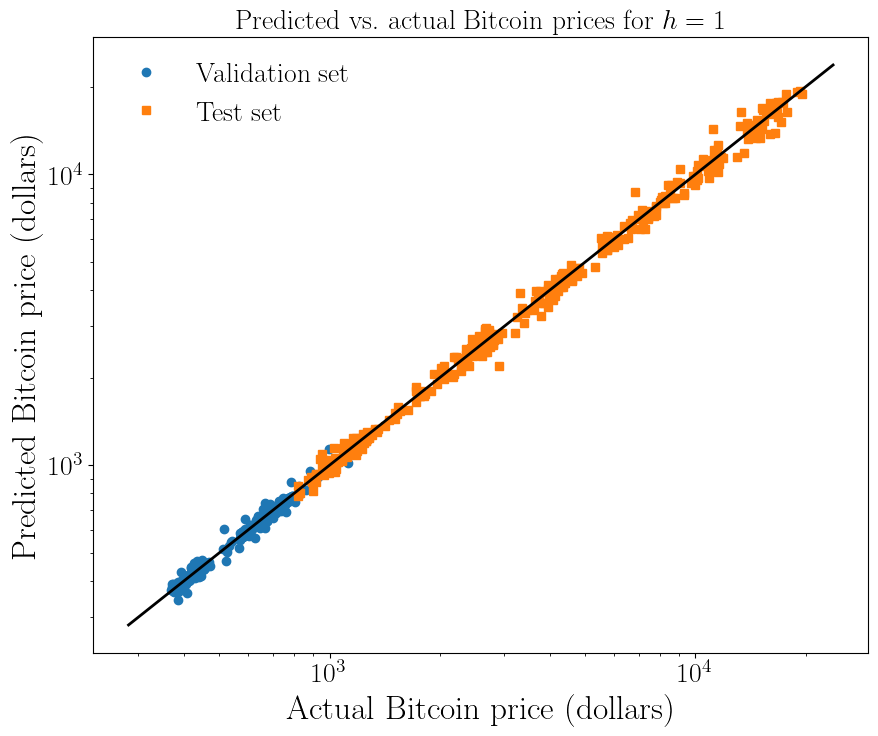

In [45]:
# Create a plot of actual vs. predicted Bitcoin prices for the best h = 1 model, which is the Ridge regression model
bundle = bundle_h1
yhat_val = H1RidgeModelWrap.calculate_predictions(bundle.X_val)
yhat_test = H1RidgeModelWrap.calculate_predictions(bundle.X_test)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(bundle.y_val, yhat_val, 'o', color=plot_colors[0], label='Validation set')
ax.plot(bundle.y_test, yhat_test, 's', color=plot_colors[1], label='Test set')
ax.set_xscale('log')
ax.set_yscale('log')
# Add black line for y = x, representing a perfect fit.
min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
x_line = np.linspace(min_val, max_val, 100) 
ax.plot(x_line, x_line, color='k', linewidth=2)
ax.set_xlabel('Actual Bitcoin price (dollars)', fontsize=24)
ax.set_ylabel('Predicted Bitcoin price (dollars)', fontsize=24)
ax.set_title(rf'Predicted vs.\ actual Bitcoin prices for $h=1$', fontsize=20)
ax.legend(prop={'size': 20}, frameon=False, loc='best', ncol=1)
fig.set_size_inches(10, 8)
fig.savefig('figures/actual_vs_predicted_h1.pdf', format='pdf', bbox_inches='tight')

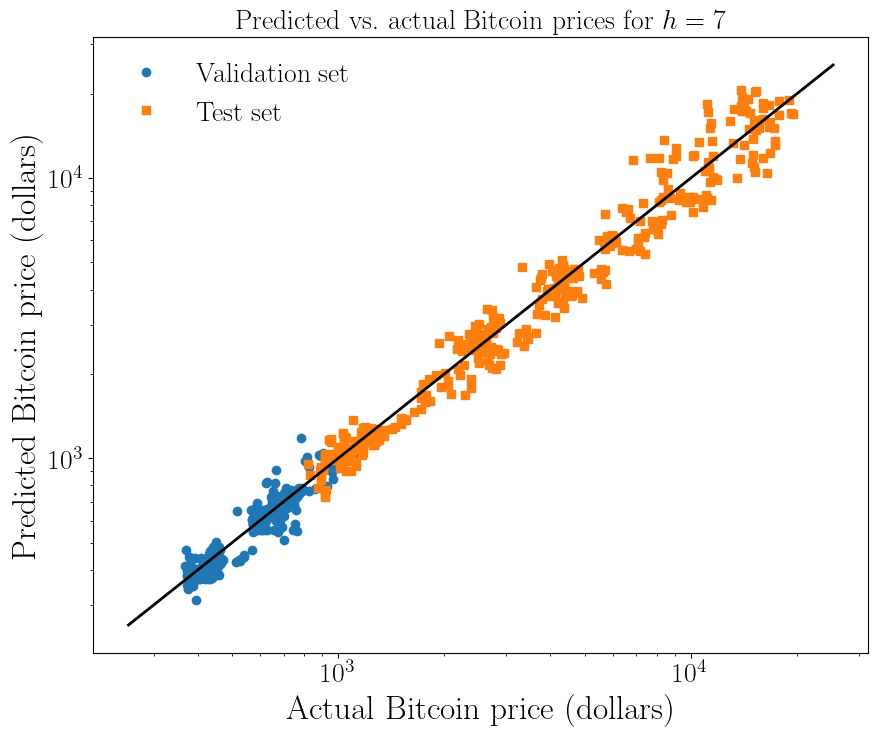

In [46]:
# Create a plot of actual vs. predicted Bitcoin prices for the best h = 7 model, which is the Linear regression model
bundle = bundle_h7
linear_h7 = [m for m in runner_h7.models if m.name == "Linear"][0]
H7LinearModelWrap = ModelWrapper("H7", linear_h7.model)
yhat_val = H7LinearModelWrap.calculate_predictions(bundle.X_val)
yhat_test = H7LinearModelWrap.calculate_predictions(bundle.X_test)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(bundle.y_val, yhat_val, 'o', color=plot_colors[0], label='Validation set')
ax.plot(bundle.y_test, yhat_test, 's', color=plot_colors[1], label='Test set')
ax.set_xscale('log')
ax.set_yscale('log')
# Add black line for y = x, representing a perfect fit.
min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
x_line = np.linspace(min_val, max_val, 100) 
ax.plot(x_line, x_line, color='k', linewidth=2)
ax.set_xlabel('Actual Bitcoin price (dollars)', fontsize=24)
ax.set_ylabel('Predicted Bitcoin price (dollars)', fontsize=24)
ax.set_title(rf'Predicted vs.\ actual Bitcoin prices for $h=7$', fontsize=20)
ax.legend(prop={'size': 20}, frameon=False, loc='best', ncol=1)
fig.set_size_inches(10, 8)
fig.savefig('figures/actual_vs_predicted_h7.pdf', format='pdf', bbox_inches='tight')

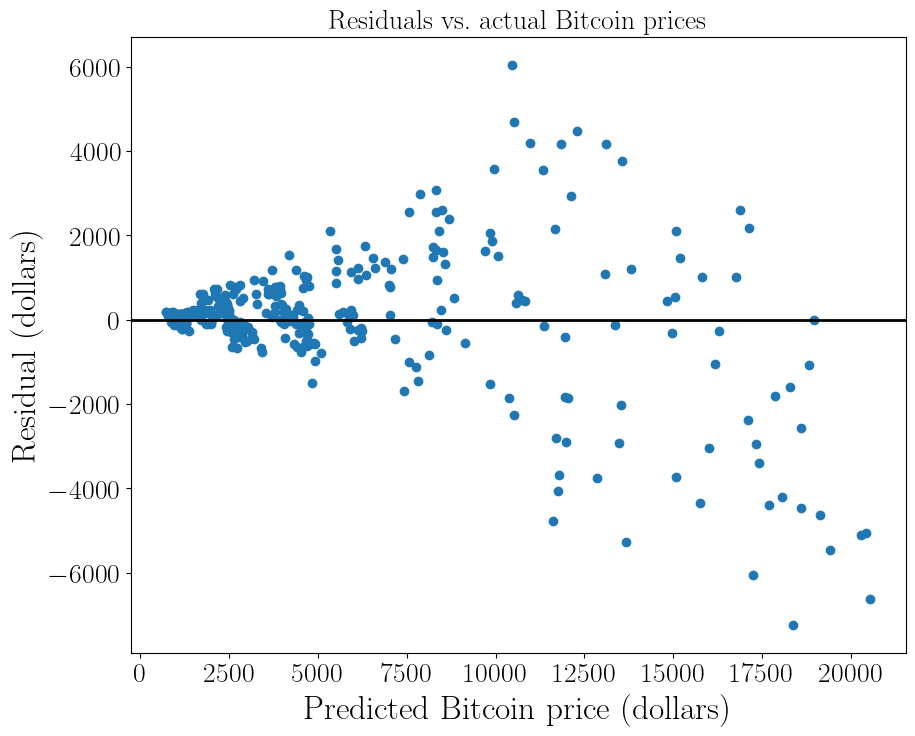

In [47]:
residuals = H7LinearModelWrap.calculate_residuals(bundle_h7.X_test, bundle_h7.y_test)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(yhat_test, residuals, 'o', color=plot_colors[0])
plt.axhline(y=0, color='k', linestyle='-', linewidth=2)
ax.set_xlabel('Predicted Bitcoin price (dollars)', fontsize=24)
ax.set_ylabel('Residual (dollars)', fontsize=24)
ax.set_title(rf'Residuals vs.\ actual Bitcoin prices', fontsize=20)
fig.set_size_inches(10, 8)
fig.savefig('figures/residuals_h7.pdf', format='pdf', bbox_inches='tight')